# Predict likelihood of default for a mobile lending service

A Telecom company, in partnership with commercial banks, is trying to leveraging the techniques of data science and machine learning to understand the behaviours of applicants and make a prediction on whether or not the applicant will default. 

Our task is to build a prototype to make the prediction on the default behaviour of applicant using the internal data of Telecom company. Most of operations including data acquisition, data processing etc. are on their virtual machine.

# Stage 1 ： Data Wrangling and Feature Engineering
****
+ Section1: Data Descriptions  
+ Section2: Call records data cleaning and Feature engineering 
+ Section3: Application download data cleaning and Feature engineering
+ Section4: Post processing
****

# Section1: Data Description

There are three tables quried from SQL database : Phone Call records; Application downloads; Search Keywords and Label of Defaults  
****
+ Table1:Phone Call records

This tables provides the call records of each applicant.

The column contains the call information as follows:
BIZ_TYPE（Business zone type：national/international）； CALL_TYPE（Call type：calling/called/call transfer）； ROAM_TYPE（Roam type：local/within province roam/outside province roam/international roam）； MSISDN（Phone number）；OTHER_PARTY（Phone number of other party）；START_TIME（starting time of call）；END_TIME（ending time of call）；CALL_DURATION（call duration）；VISIT_AREA_CODE（visit area code when call）；CALLED_HOME_CODE（the other party home code）；CALLED_CODE（the other party visiting area code）；CHARGING_DURATION（charging duration）；DAY_ID_D（date of call）；PRVNCE_ID_D （Province ID）

Each row corresponds to a record for call information; one user(same phone number_MSISDN) may contain multiply records (call records for different other parties)
****
+ Table2: Application downloads

This table provides the Application download information of each applicant 

The column contains the Application download information as follows:
MDN（Phone number）；TYPE_CODE1（application download type code (parent)）；TYPE_NAME1（application download name (parent)）；TYPE_CODE2（application download type code(children)）；TYPE_NAME2（application download name(children)）；CNT；FLUX（Download Flux_B）；DUR（Download duration_S）;DATA_DAY（Date of data collection）

Each row corresponds to a record for application download; one user(same phone number_MSN) may contain multiply download records (different types of downloaded applications_TYPE_CODE1/2)
****

+ Table3: Label of Defaults  

This table provides the situation of defaults of each applicant (Label data)

The column names are PHONE	（Phone number）；RESPONSE（Whether defaults or not)

Each row corresponds to the situation of defaults: 0 repay; 1 default
****

# Section2: Phone Call records data cleaning & Feature creation

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib as plt

In [ ]:
# As the first 15 lines are comment, we skip that by 'skiprows' when loading the data
df=pd.read_csv('E:/xjdata/TF_CREDIT_XJD_CDR1.csv',skiprows=[i+1 for i in range(15)])

****
+ 2.1 Dealing with Missing value(NA)

In [ ]:
df.isnull().sum()

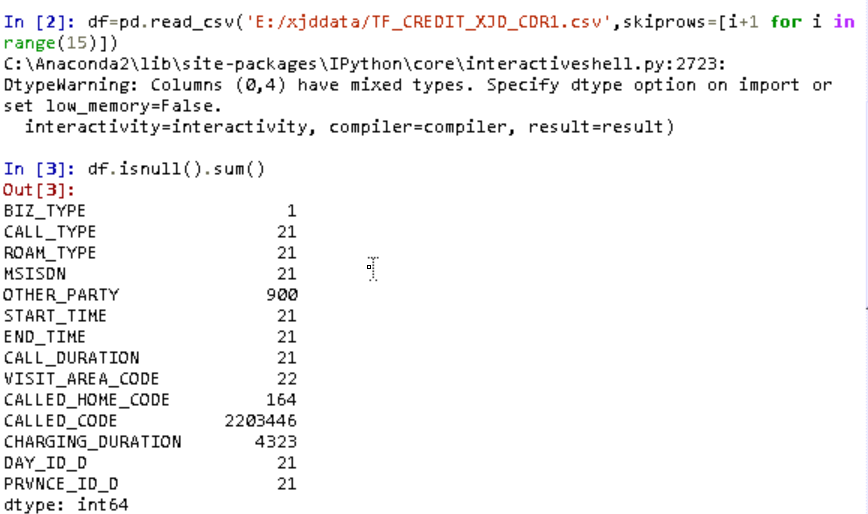

In [17]:
Image(filename='~/Jupyter/Img/2.20.png',width=400,height=400)

The majority of missing value (NA) comes from CALLED_CODE（other party visiting area code）；CHARGING_DURATION（charging duration). As similar information of above two variables are also contained in the variables of CALLED_HOME_CODE（other party home code）and CALL_DURATION（call duration), in order to reserve most of data, we decide drop this two columns.

In [ ]:
df.drop(['CALLED_CODE','CHARGING_DURATION'],axia=1,inplace=True)
df.isnull().sum()

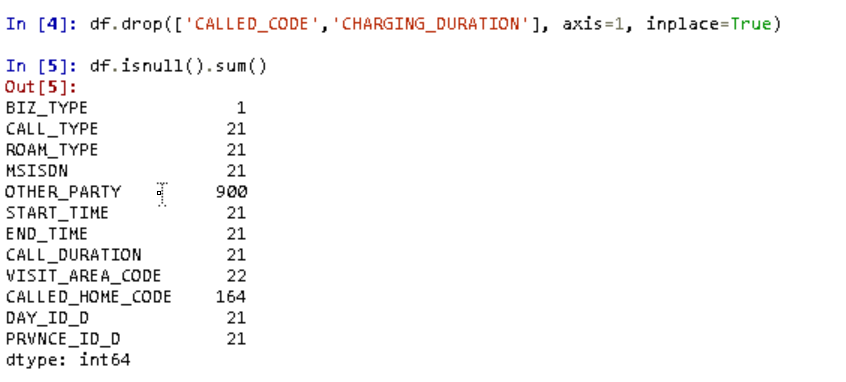

In [19]:
Image(filename='~/Jupyter/Img/2.21.png',width=400,height=400)

After drop the two columns of CALLED_HOME_CODE（other party home code）and CALL_DURATION（call duration, we check the missing value again, finding that the missing values are reduced significantly. We will remove all of rows that contain missing vaules 

In [ ]:
df=df.dropna()
df.isnull().sum()

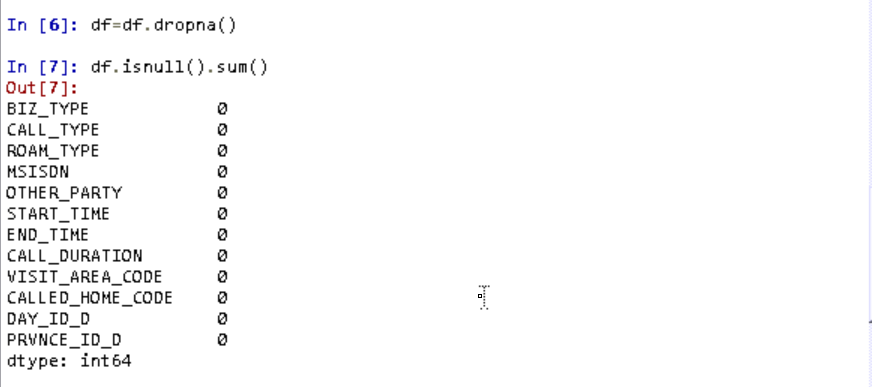

In [20]:
Image(filename='~/Jupyter/Img/2.22.png',width=400,height=400)

After dropping the missing values, the data are shown as follows 

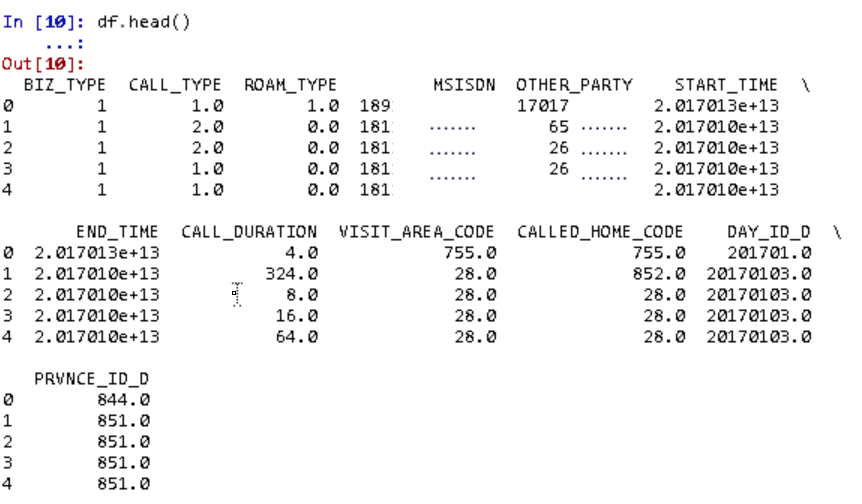

In [2]:
Image(filename='~/Jupyter/Img/2.23.png',width=400,height=400)

****
+ 2.2 Aggregate data of same user(same phone number)

2.21 Aggregate call duration based on call type

Sum the call durations for each user according to the call types (calling/called/call transfer). Then unstack the total call duration of different call types from rows to columns. 
Obtain the total call duration for different call types (calling/called/call transfer) for each user.

In [ ]:
df1= df['CALL_DURATION'].groupby([df['MSISDN'],df['CALL_TYPE']]).sum().unstack().fillna(0)

In [ ]:
df1.columns=['Phone','Calling_Duration','Called_Duration','Transfered_Duration']
df1.head()

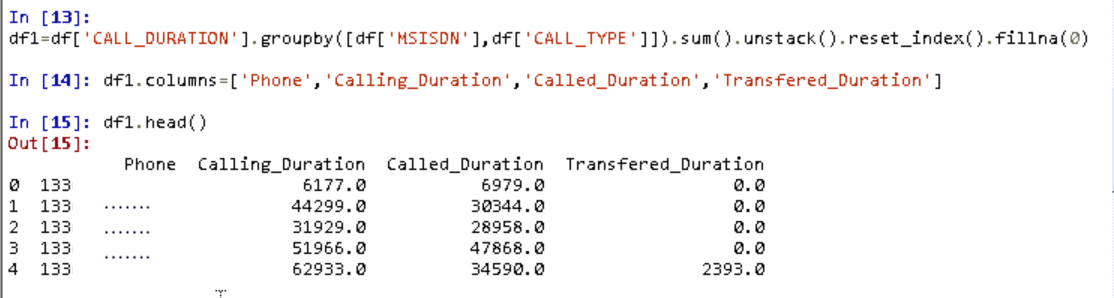

In [3]:
Image(filename='~/Jupyter/Img/2.30.png',width=400,height=400)

The column names for new dataframe df1 are Phone，Calling_Duration，Called_Duration，Transfered_Duration；Each row represents one user(phone number)

****
2.22 Aggregate call duration based on business zone type

Same procedure is taken for business zone type feature: Sum the call duration for each user according to the business zone types (domestic/international). Then unstack the call duration of business zone types from rows to columns. Obtain the total call duration for business zone type (domestic/international)

Since the BIZ_TYPE data contain mixture data type, for example, the domestic business type is represented by integer(int) type '1' or string (str) type '01', we need to unify the data type first before aggregation.

In [ ]:
df['BIZ_TYPE'].value_counts()
df['BIZ_TYPE'].replace({'01':1, '02':2}, inplace=True)

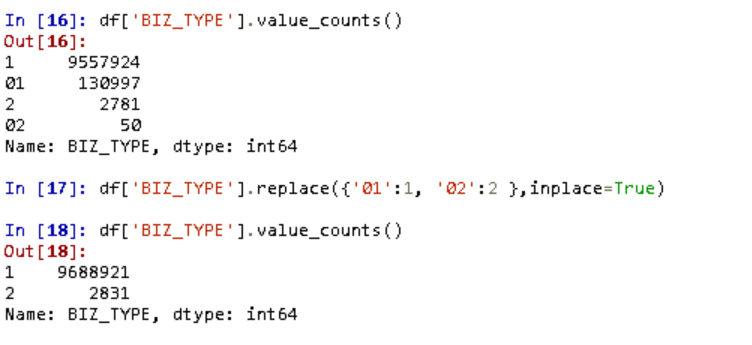

In [30]:
Image(filename='~/Jupyter/Img/2.32.png',width=400,height=400)

Then aggregate the call duration based on business zone type 

In [ ]:
df2= df['CALL_DURATION'].groupby([df['MSISDN'],df['BIZ_TYPE']]).sum().unstack().fillna(0)

In [ ]:
df2.columns=['Phone','Domestic_Duration','International_Duration']
df2.head()

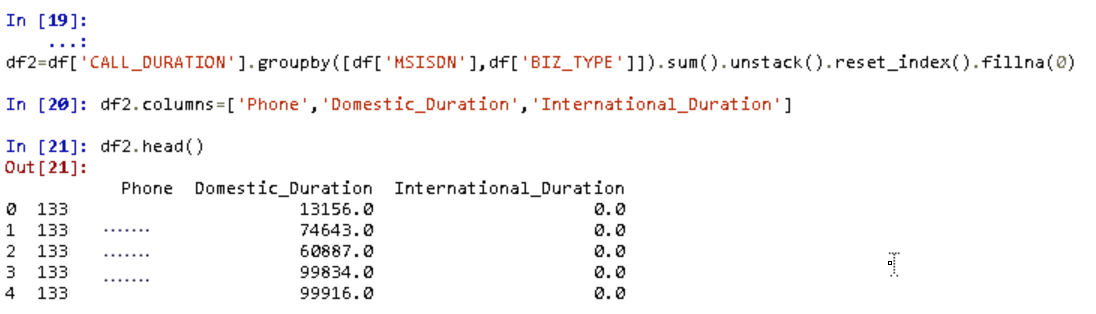

In [4]:
Image(filename='~/Jupyter/Img/2.33.png',width=400,height=400)

The column names of new dataframe df2 are Phone，Domestic_Duration，International_Duration; Each row represents one user(phone number)

****
2.23 Aggregate roam information, the other party information, visiting area information and called home code information

Create a series of new features based on the data of ‘ROAM_TYPE’, 'OTHER_PARTY', 'VISIT_AREA_CODE' and 'CALLED_HOME_CODE':
1.	roam ratio: use the ratio of number of roam calls/number of all (roam + non-roam) calls to represent the roam levels of each user.
2.	diversity of the other party: count the distinct calling numbers and called numbers of each user to represent the diversity of user’s contacts.
3.	diversity of visiting area: count the distinct visiting places of each user to represent the diversity of user’s visiting area/travel footprint
4.	diversity of geography locations of the other party: count the distinct numbers of geography location for each user’s contacts to represent the geo-diversity of user’s contacts.

In [ ]:
functions={'ROAM_TYPE': lambda x: float(np.count_nonzero(x))/float(len(x)),  #Roam ratio
           'OTHER_PARTY': lambda x: len(set(x)),
           'VISIT_AREA_CODE': lambda x: len(set(x)),
           'CALLED_HOME_CODE': lambda x: len(set(x))
          }

In [ ]:
df3=df.groupby(df['MSISDN']).agg(functions).reset_index()
df3.head()

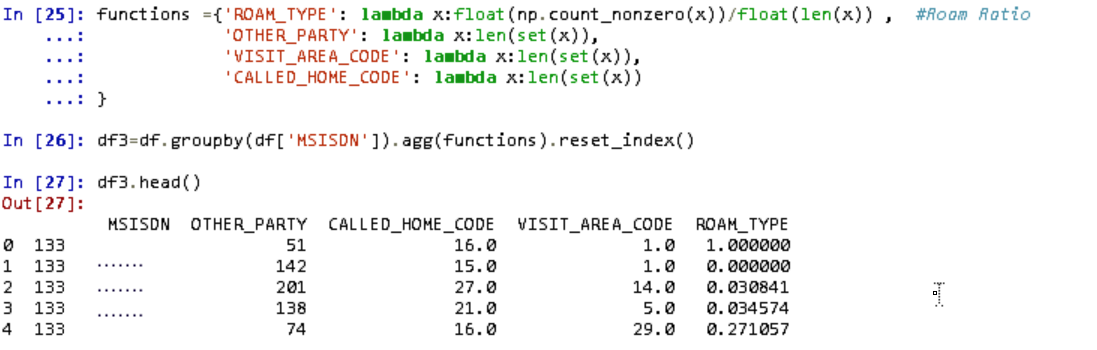

In [5]:
Image(filename='~/Jupyter/Img/2.40.png',width=500,height=500)

In [ ]:
df3.columns=['Phone','Contact_Diversity','Contact_Area_Diversity','Visiting_Area_Diversity','Roam_Ratio']
df3.head()

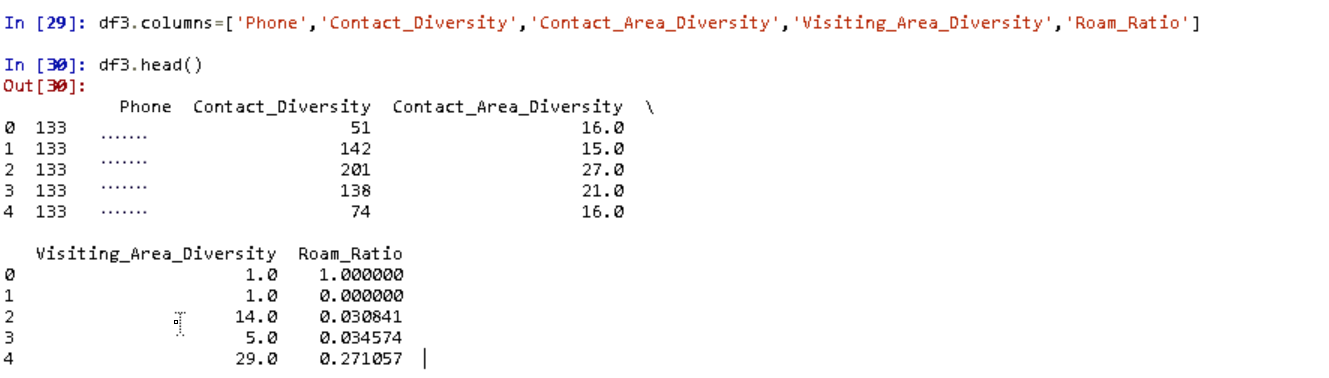

In [6]:
Image(filename='~/Jupyter/Img/2.41.png',width=500,height=500)

The column names of new dataframe df3 are Phone，Contact_Diversity，Contact_Area_Diversity ,Visiting_Area_Diversity, Roam_Ratio; Each row represents one user(phone number)

****
+ 2.3 Merge table and build new dataframe

Merge df1, df2 and df3; obtain a new dataframe contains aggregate features for each user.

In [ ]:
df4=pd.merge(df1,df2, on='Phone')
df5=pd.merge(df4,df3, on='Phone')
df5.head()

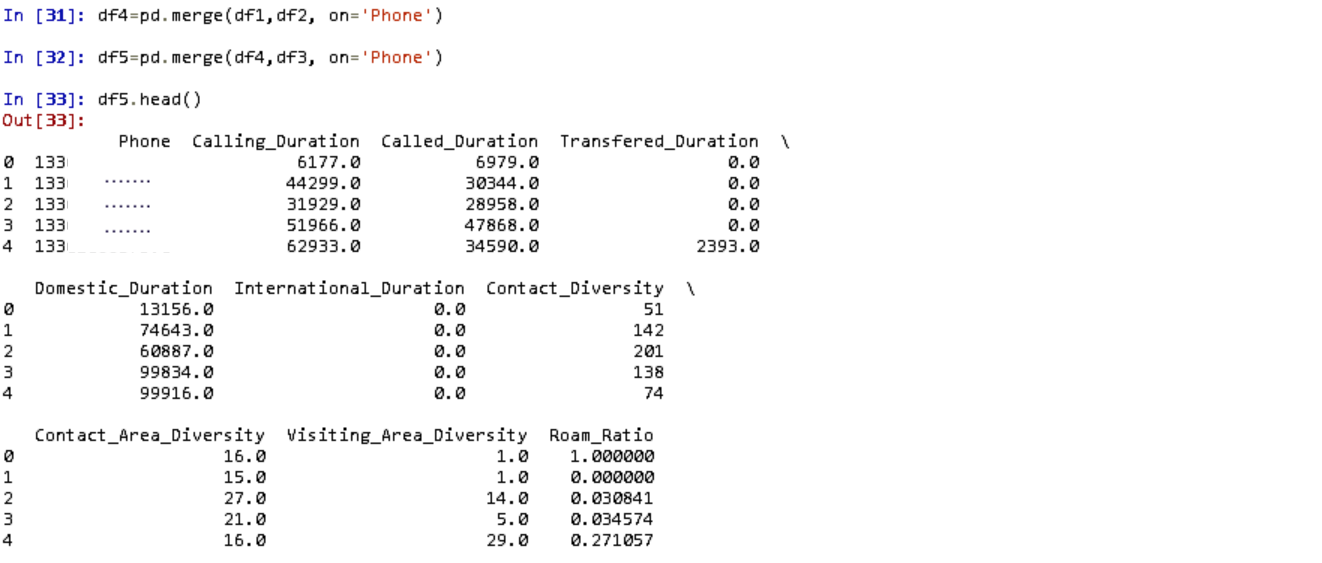

In [7]:
Image(filename='~/Jupyter/Img/2.50.png',width=500,height=500)

For each user, the features are Contact_Diversity Contact_Area_Diversity,Visiting_Area_Diversity, Roam_Ratio, Calling_Duration，Called_Duration，Transfered_Duration，Domestic_Duration，International_Duration。

In [ ]:
df5.to_csv('E:/xjdata/Call.csv'')

# Section3: Application downloads cleaning and Feature creation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [ ]:
df=pd.read_csv('E:/xjdata/TF_CREDIT_XJD_APP1.csv', encoding='gbk')
df.head()

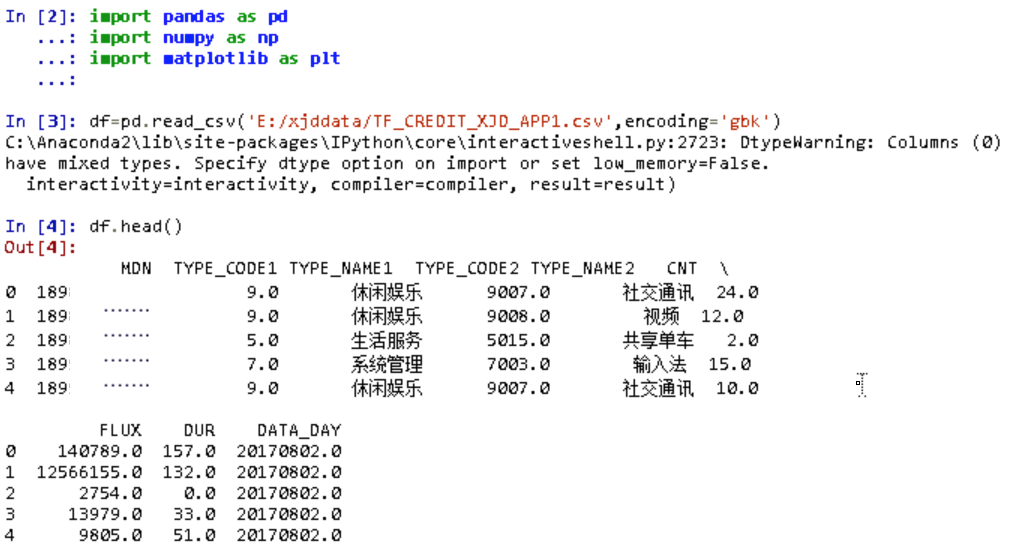

In [9]:
Image(filename='~/Jupyter/Img/3.0.png',width=500,height=500)

****
3.1 Deal with missing values (NA)

In [ ]:
df.isnull().sum()

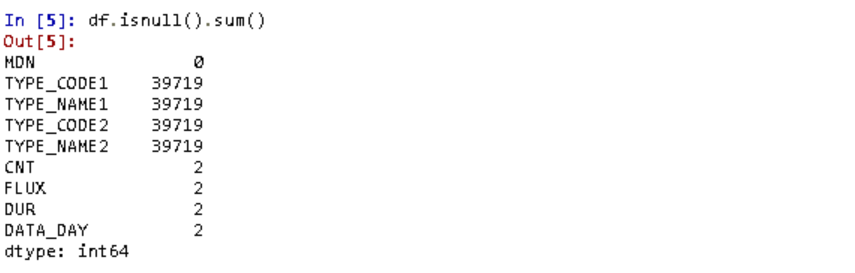

In [56]:
Image(filename='~/Jupyter/Img/3.2.png',width=500,height=500)

The majority of missing values are contained in TYPE_CODE1；TYPE_NAME1；TYPE_CODE2；TYPE_NAME2. Drop the missing values (NA)

In [ ]:
df=df.dropna()
df.isnull().sum()

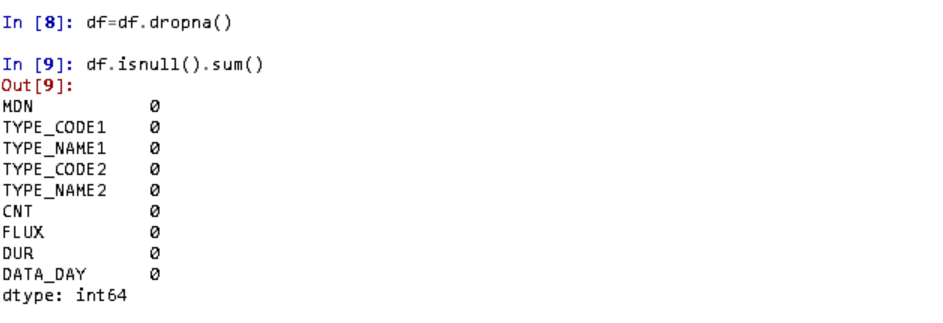

In [57]:
Image(filename='~/Jupyter/Img/3.1.png',width=500,height=500)

****
+ 3.2 Aggregate data by user(same phone number_MDN)

The main information reflected from application downloads table is downloaded application types and flux data. The downloaded application types contain primary types（TYPE_CODE1 and TYPE_NAME1） and secondary types （TYPE_CODE2 and TYPE_NAME2）

3.21 Aggregate the download flux information based on application types

The new features are created by three steps: 
1) As the TYPE_CODE and TYPE_NAME are one-to-one mapping; we use TYPE_CODE to represent downloaded application types.  There are 11 primary application types and 70 secondary application types. We use primary application types (TYPE_CODE1). 

2) The unit time flux information is represented by download flux divide time, that is, FLUX/DUR.

3) Sum the unit time download flux based on different downloaded application types(TYPE_CODE1). Then unstack that from rows to columns. Obtain the total download flux per unit time of each user for different downloaded applications. 

1）Check the distinct number of secondary type (TYPE_CODE2)

In [ ]:
len(set(df['TYPE_CODE2']))

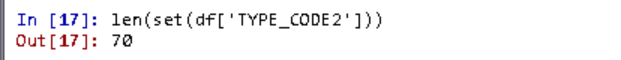

In [55]:
Image(filename='~/Jupyter/Img/3.8.png',width=300,height=300)

There are 70 distinct secondary types. If chosen as features vector, a dimension reduction is needed futher. So we choose the primary types (TYPE_CODE1) as feature vector.

2）Generate new feature: the download flux per unit time (FLUX/DUR)

In [ ]:
df['Unit_Flux']=df['Flux']/df['DUR']
df.head()

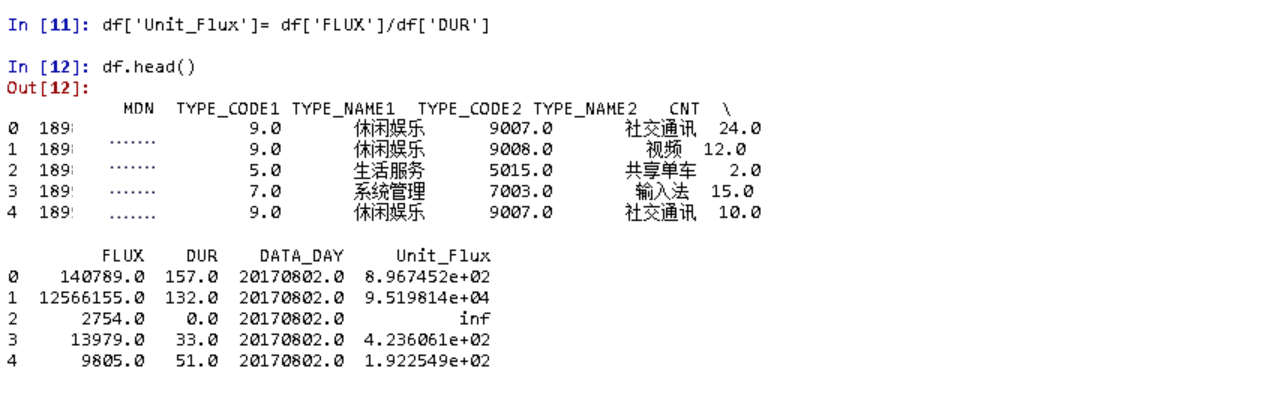

In [10]:
Image(filename='~/Jupyter/Img/3.10.png',width=500,height=500)

Remove the rows where download duration is zero but download flux is non zero

In [ ]:
df=df[df['DUR']!=0]
df.head()

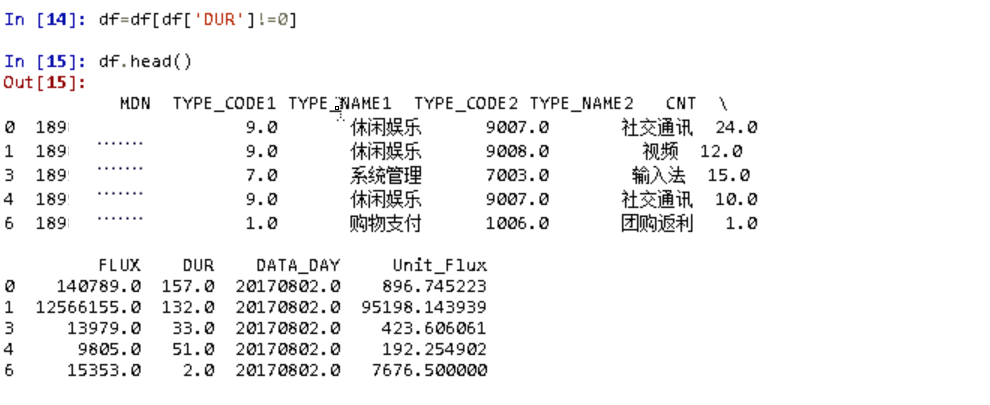

In [11]:
Image(filename='~/Jupyter/Img/3.4.png',width=500,height=500)

3）Aggregate the download flux per unit time based on different types of downloaded applications (TYPE_CODE1)

In [ ]:
df1=df['Unit_Flux'].groupby([df['MDN'],df['TYPE_CODE1']]).sum().unstack().reset_index().fillna(0)
df1.columns=['Phone','T1_Flux','T2_Flux','T3_Flux','T4_Flux','T5_Flux','T6_Flux','T7_Flux','T8_Flux','T9_Flux','T10_Flux','T11_Flux']
df1.head()

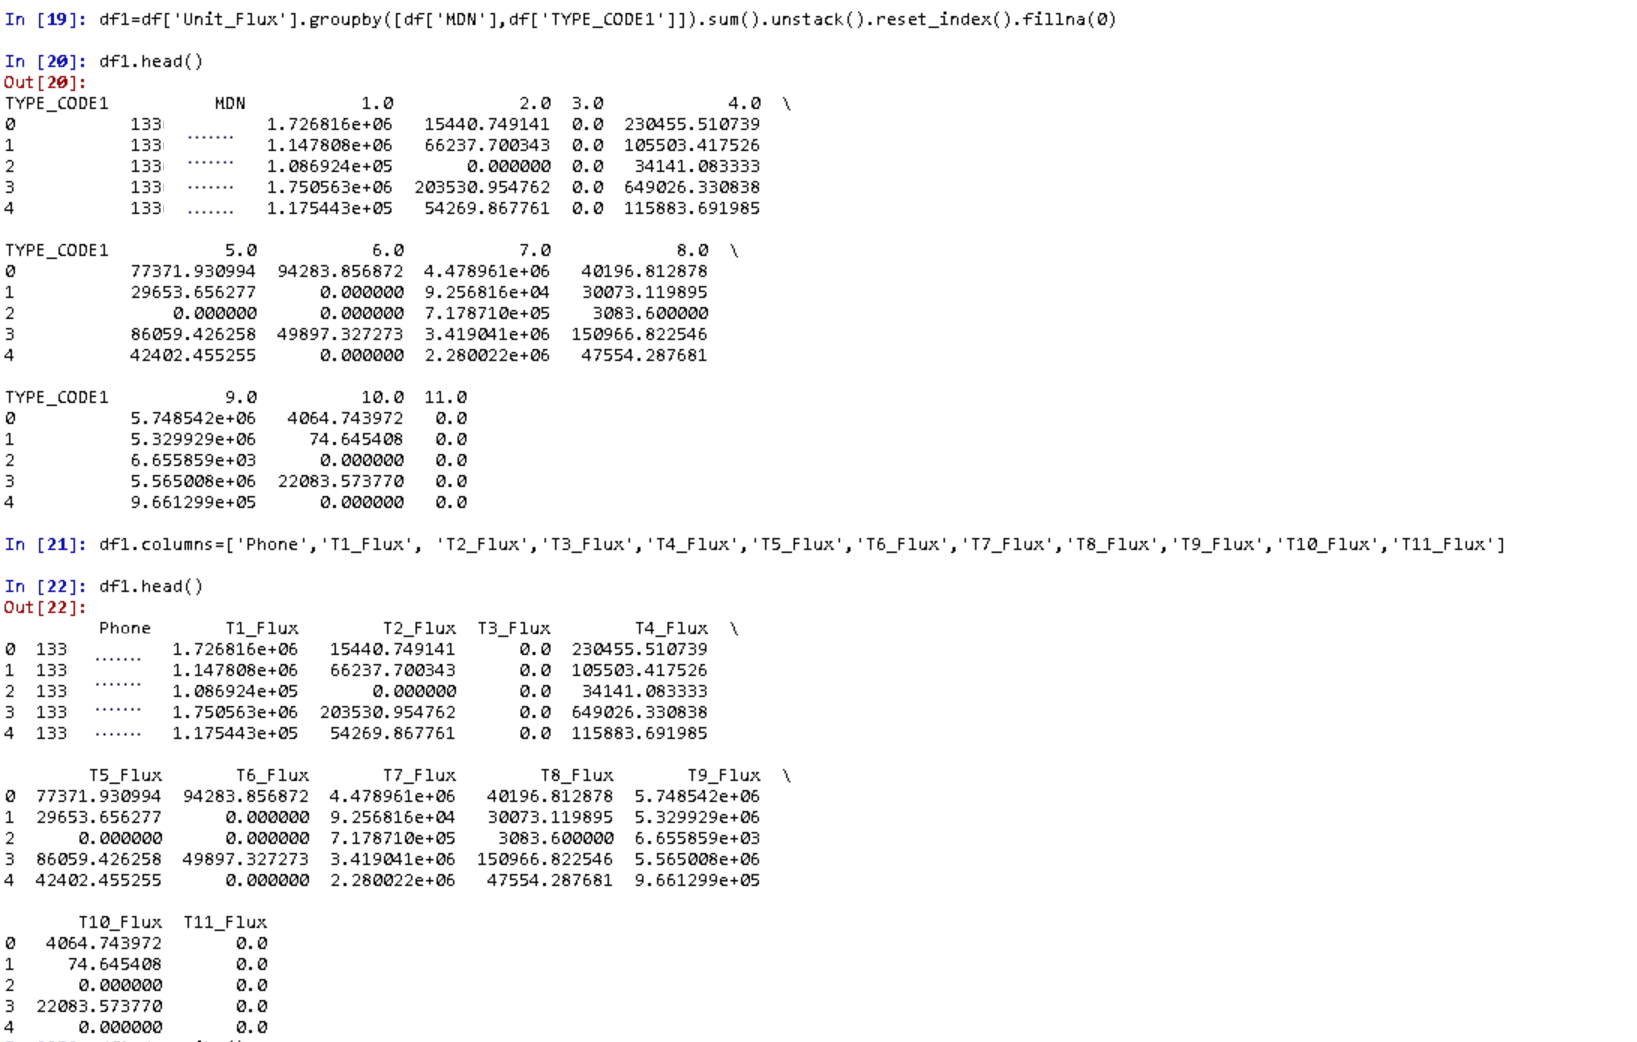

In [12]:
Image(filename='~/Jupyter/Img/3.9.png',width=1000,height=1000)

Get the new dataframe of application download information (T1_Flux-T11_Flux) for each user 

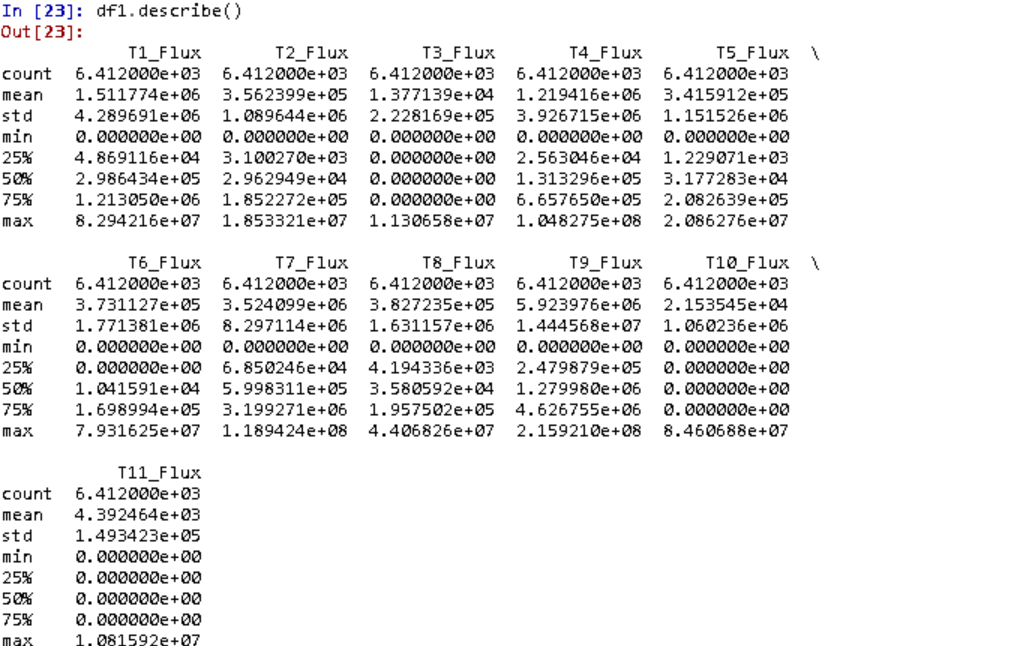

In [51]:
Image(filename='~/Jupyter/Img/3.6.png',width=500,height=500)

In [ ]:
df1.to_csv('E:/xjdata/app.csv'')

# Section4: Post-processing 

In [28]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df1 = pd.read_csv('E:/xjddata/Call.csv')
df2 = pd.read_csv('E:/xjddata/app.csv')
df = pd.merge(df1, df2, on = 'Phone')
df.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1, inplace=True)

In [ ]:
df3 = pd.read_csv('E:/xjddata/Y1217.csv')
df3.columns = ['Phone','Response']
dff = pd.merge (df, df3, on='phone')
dff.head()

In [ ]:
dff.to_csv('E:/xjddata/data.csv', index=False)

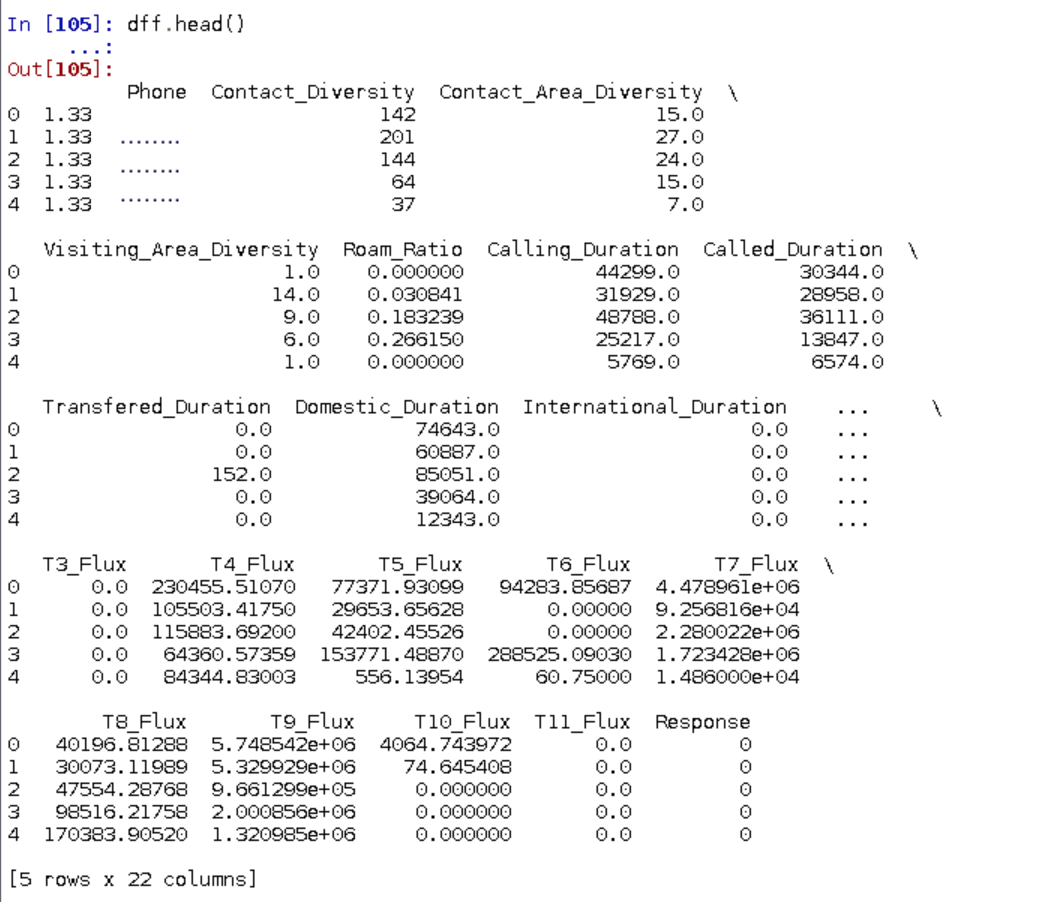

In [23]:
Image(filename='~/Jupyter/Img2/1.1.png',width=600,height=600)

The statistical information of all features are shown as follows

In [ ]:
df.describe()

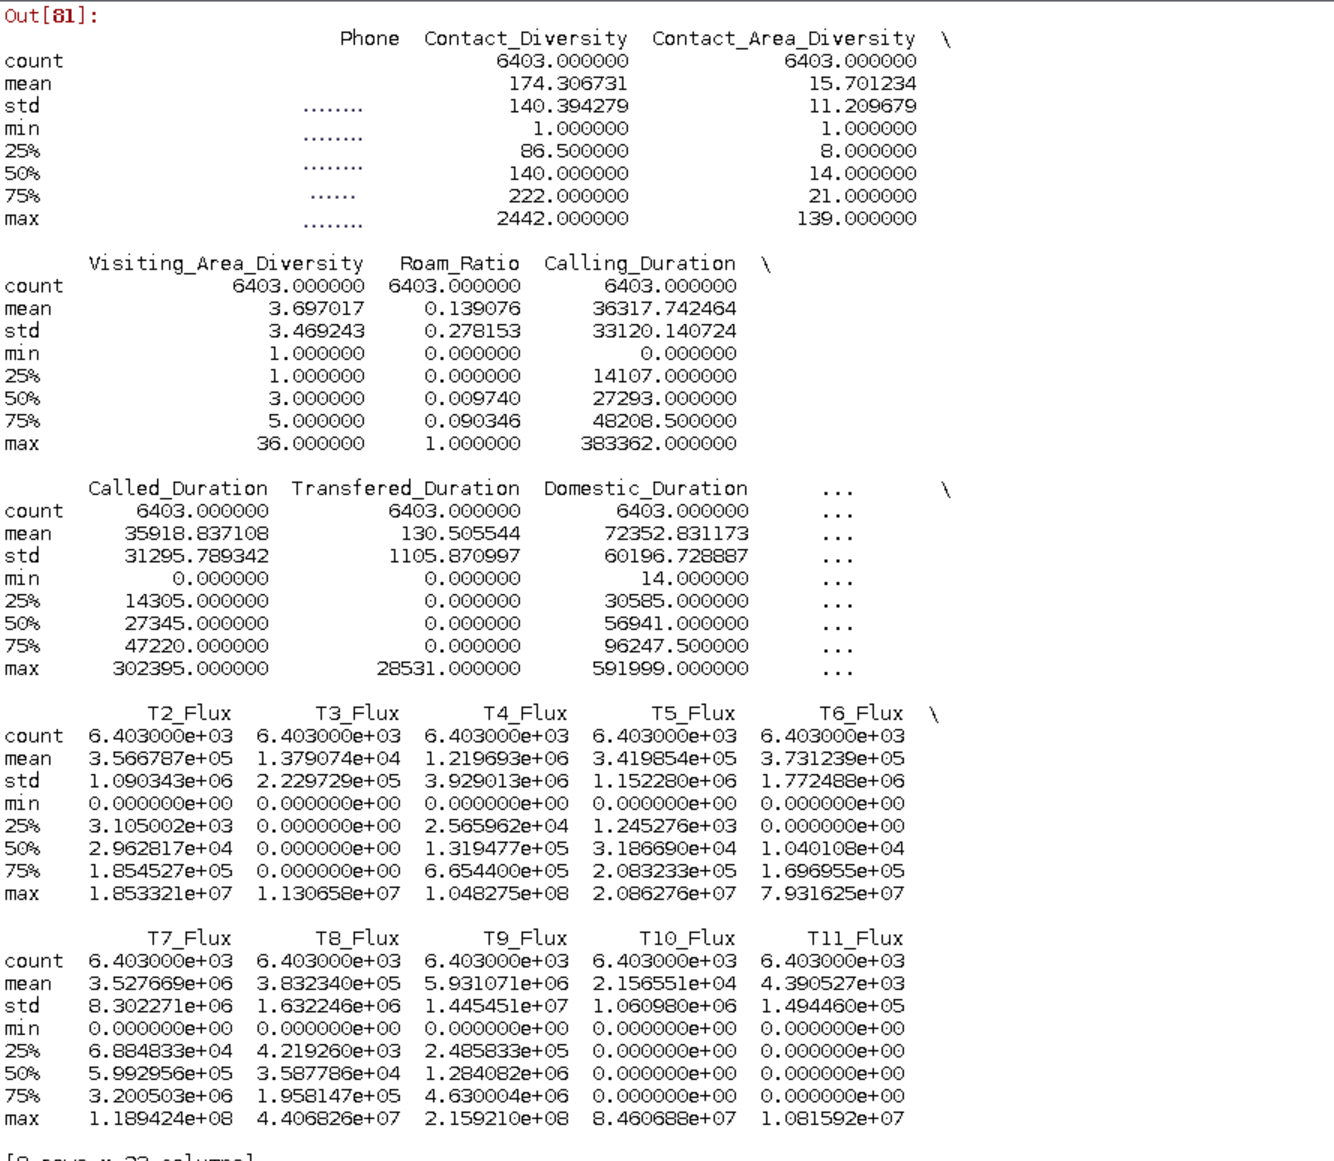

In [27]:
Image(filename='~/Jupyter/Img2/1.23.png',width=1000,height=1000)

It is discovered that the features of calling duration and downloading flux have a wide distribution interval, which may need a further processing. We plot the box plot for feature distrbutions

In [ ]:
df1=dff[dff['Response']==1]
df0=dff[dff['Response']==0]

In [ ]:
def box_plot(column):
    data=[dff1.iloc[:,column],dff0.iloc[:,column]]
    fig,ax=plt.subplots()
    ax.boxplot(data, vert=True)
    ax.set_xticklabels(['Defaults','Repayment'])
    as.set_title(title[column])
    plt.show()

In [ ]:
for i in range(len(dff.columns-1)):
    box_plot(i+1)

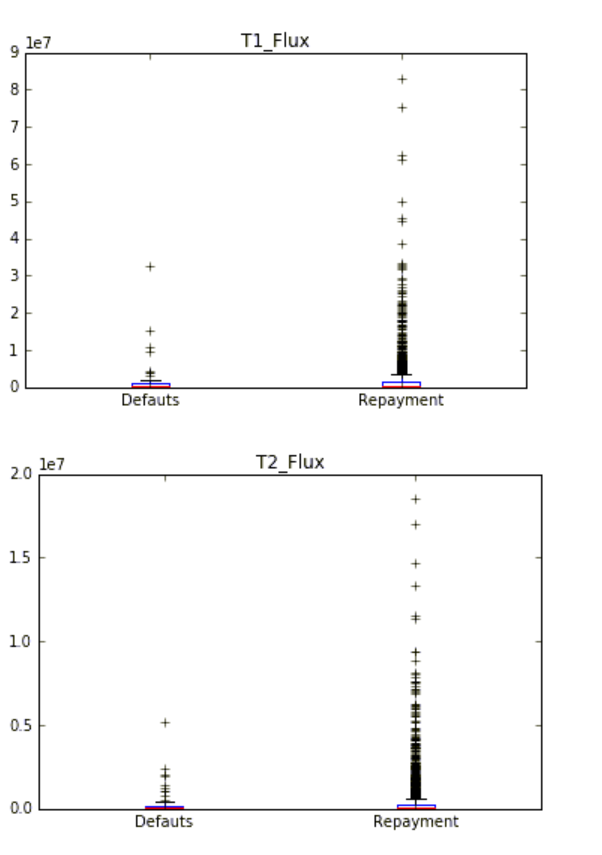

In [18]:
Image(filename='~/Jupyter/Img2/2.3.png',width=400,height=400)

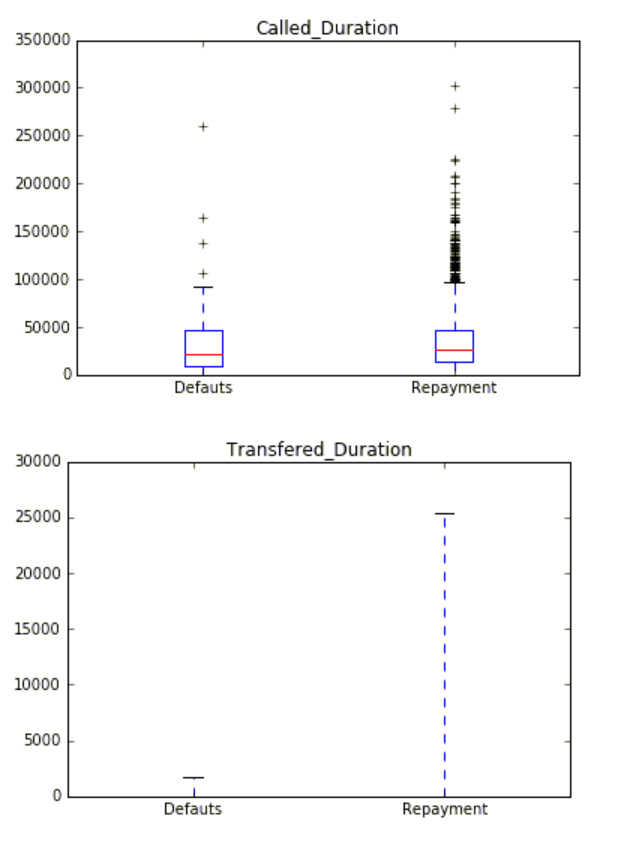

In [19]:
Image(filename='~/Jupyter/Img2/2.6.png',width=400,height=400)

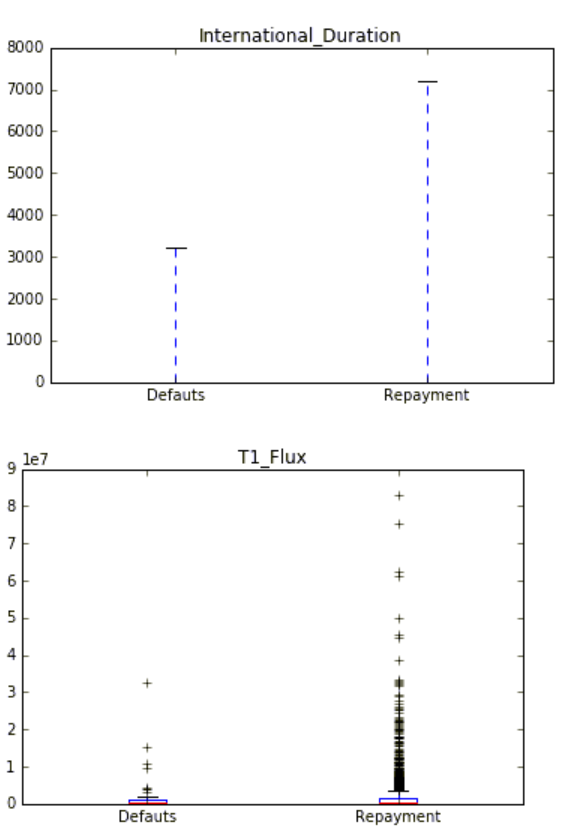

In [20]:
Image(filename='~/Jupyter/Img2/2.7.png',width=400,height=400)

From the boxplot, we find that as the distribution interval of features in the downloaded application is large, lots of values are treated as outliers. We think about deal with the data by square root to reduce the distribution interval. The data of Transfered_Duration and International_Duration data is very ununiformed, like a line in the plot; we can think about to transfer them to 0-1 variables.